In [9]:
# Weather Predictor using Historic Weather data(Scrapped From UIUC weather website)

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.backend import square, mean

In [289]:
train_data = pd.read_csv('~/Desktop/Urbana_Hitorical_Weather.csv')
df = pd.DataFrame(train_data)
Day_of_Year = []
Date = []

for x in train_data['Day']:
    temp = datetime.strptime(x, '%Y-%m-%d')
    Date.append(temp)
    Day_of_Year.append(temp.timetuple().tm_yday)

df['Day_of_Year'] = Day_of_Year
df['Day_of_Year'].astype(str).astype(float)
df['Date'] = Date
High_hour = [];Low_hour = []
for htime in train_data['High_Time']:
    temp = datetime.strptime(htime, '%I:%M %p')
    High_hour.append(temp)
for ltime in train_data['Low_Time']:
    temp = datetime.strptime(ltime, '%I:%M %p')
    Low_hour.append(temp)
    
df['High_Hour'] = High_hour
df['High_Hour'] = df['High_Hour'].dt.hour
df['High_Hour'].astype(str).astype(float)
df['Low_Hour'] = Low_hour
df['Low_Hour'] = df['Low_Hour'].dt.hour
df['Low_Hour'].astype(str).astype(float)

0        4.0
1        1.0
2       23.0
3        5.0
4        2.0
        ... 
1539     6.0
1540     0.0
1541    23.0
1542    23.0
1543     0.0
Name: Low_Hour, Length: 1544, dtype: float64

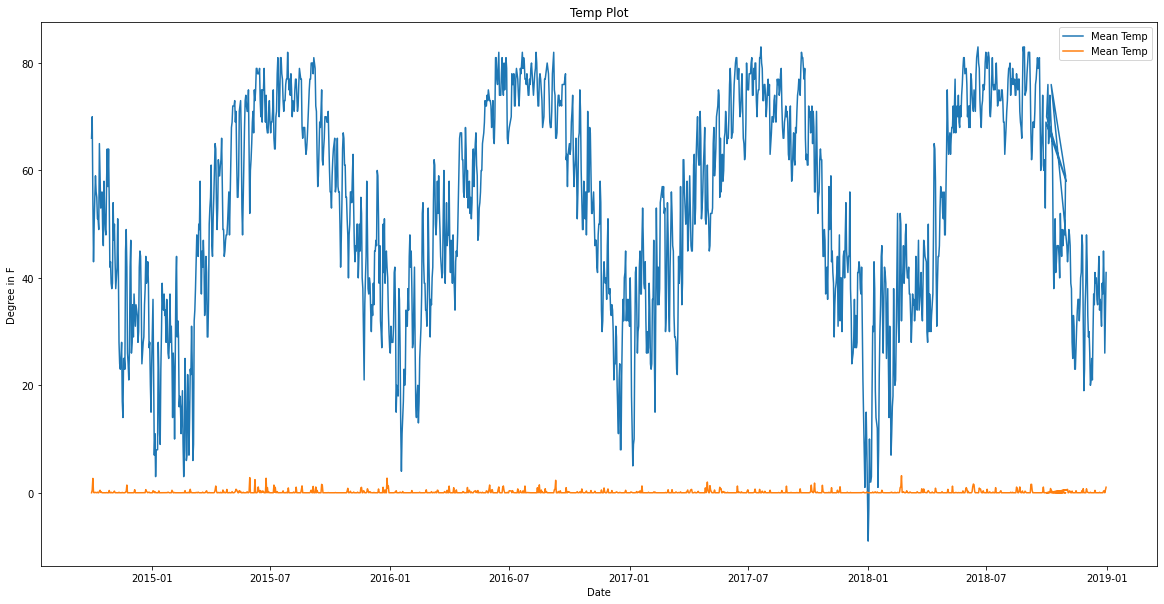

In [441]:
x = df['Date']
y1 = df['Temperature_Mean'];y2 = df['Precipitation'];

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, y1, label='Mean Temp')
ax.plot(x, y2, label='Mean Temp')
ax.set_xlabel('Date') 
ax.set_ylabel('Degree in F')  
ax.set_title("Temp Plot")  
ax.legend() 


In [442]:
target = ['Temperature_Mean', 'Precipitation']

In [443]:
shift_days = 1

In [444]:
df_targets = df[target].shift(-shift_days)

In [445]:
df_targets.head(5)

,Temperature_Mean,Precipitation
0,70.0,0.48
1,55.0,2.67
2,43.0,0.09
3,50.0,0.00
4,55.0,0.06


In [446]:
df[target].head(shift_days + 5)

,Temperature_Mean,Precipitation
0,66,0.00
1,70,0.48
2,55,2.67
3,43,0.09
4,50,0.00
5,55,0.06


In [447]:
df_targets.tail()

,Temperature_Mean,Precipitation
1539,45.0,0.29
1540,39.0,0.39
1541,26.0,0.00
1542,41.0,1.03
1543,NaN,NaN


In [448]:
x_data = df.drop(columns = ['Day', 'High_Time', 'Low_Time', 'Date'])
x_data = x_data.values[0:-shift_steps];x_train = x_data[0:round(len(x_data)*0.8)];x_test = x_data[round(len(x_data)*0.8):]
y_data = df_targets.values[:-shift_steps];y_train = y_data[0:round(len(x_data)*0.8)];y_test = y_data[round(len(x_data)*0.8):]
print(len(x_data)); print(len(y_data))
num_x_signals = x_train.shape[1];num_y_signals = y_train.shape[1]; num_train = len(x_train)

1520
1520


In [449]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)

In [450]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

In [451]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)
#validation_data = (np.expand_dims(x_test_scaled, axis=0),
                  # np.expand_dims(y_test_scaled, axis=0))

(1216, 8)
(1216, 2)


In [452]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [453]:
batch_size = 10; sequence_length = 14
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [454]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(10, 14, 8)
(10, 14, 2)


In [469]:
def model_fn():
    model = Sequential([
        GRU(units=512,
            return_sequences = True,
           input_shape = (None, 8)),
        Dense(2,activation = 'sigmoid')
    ])
    if False:
        from tensorflow.python.keras.initializers import RandomUniform

        init = RandomUniform(minval=-0.01, maxval=0.01)

        model.add(Dense(num_y_signals,
                        activation='linear',
                        kernel_initializer=init))
    model.compile(optimizer=RMSprop(lr=0.001),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    return model
model = model_fn()

In [470]:
model.fit(generator, epochs = 10, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 2s 197ms/step - loss: 0.0452 - accuracy: 0.9957
Epoch 2/10
10/10 [==============================] - 1s 118ms/step - loss: 0.0285 - accuracy: 0.9936
Epoch 3/10
10/10 [==============================] - 1s 116ms/step - loss: 0.0229 - accuracy: 0.9957
Epoch 4/10
10/10 [==============================] - 1s 115ms/step - loss: 0.0194 - accuracy: 0.9964
Epoch 5/10
10/10 [==============================] - 1s 118ms/step - loss: 0.0115 - accuracy: 0.9993
Epoch 6/10
10/10 [==============================] - 1s 120ms/step - loss: 0.0133 - accuracy: 0.9964
Epoch 7/10
10/10 [==============================] - 1s 117ms/step - loss: 0.0129 - accuracy: 0.9971
Epoch 8/10
10/10 [==============================] - 1s 118ms/step - loss: 0.0119 - accuracy: 0.9950
Epoch 9/10
10/10 [==============================] - 1s 117ms/step - loss: 0.0115 - accuracy: 0.9971
Epoch 10/10
10/10 [==============================] - 1s 120ms/step - loss: 0.0113 - accuracy: 0.9936

In [471]:
def plot_comparison(x_data, y_data):
    #Plot the predicted and true output-signals.

    x = x_data
    y_true = y_data
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(16,9))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

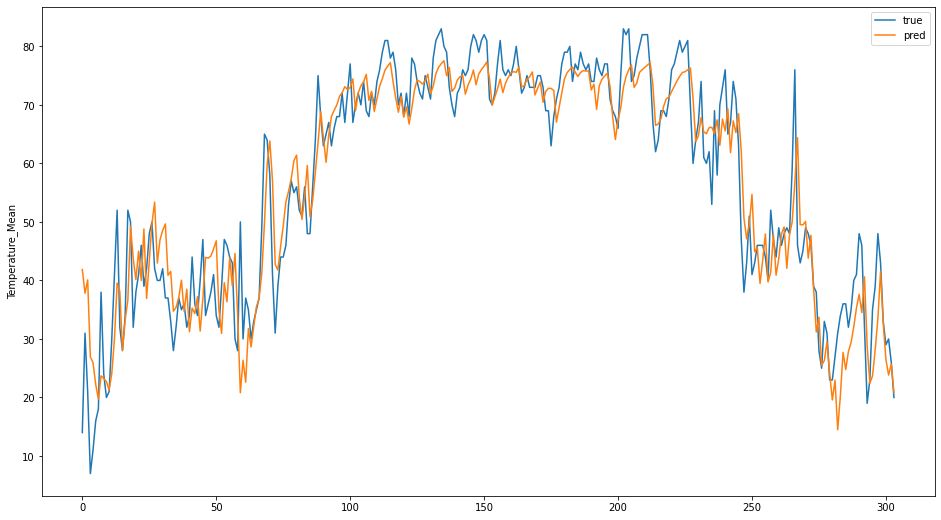

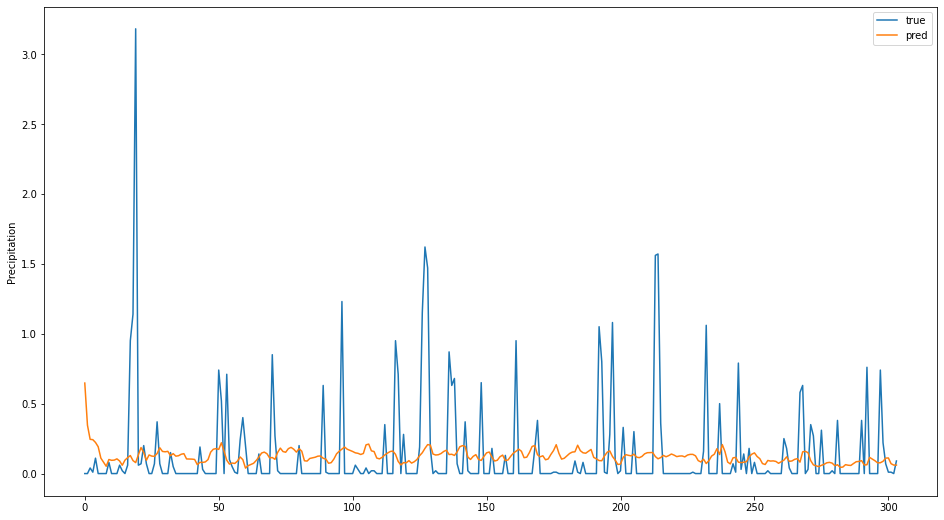

In [472]:
plot_comparison(x_test_scaled,y_test)